In [13]:
import numpy as np
import torch
import pickle
import time
import os
%matplotlib inline
import matplotlib.pyplot as plt

# Convert to DGL format and save with pickle

In [1]:
import os
from pathlib import Path
os.chdir('../../') # go to root folder of the project
print(os.getcwd())
project_root = Path.cwd() / "data/molecules"
print(project_root) 

/home/zsy123/IMGT-MPN-main
/home/zsy123/IMGT-MPN-main/data/molecules


In [2]:
import pickle

%load_ext autoreload
%autoreload 2

from data.molecules import MoleculeDatasetDGL 

from data.data import LoadData
from torch.utils.data import DataLoader
from data.molecules import MoleculeDataset
from dgllife.utils import BaseAtomFeaturizer,WeaveAtomFeaturizer, CanonicalBondFeaturizer, smiles_to_bigraph, EarlyStopping


No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading some PyTorch models, missing a dependency. No module named 'sympy'
No module named 'sympy'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'sympy'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'


In [3]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from rdkit import Chem
import requests
import gzip
import os

# 设置数据集路径
data_dir = project_root / 'ClinTox/clintox.csv.gz'
data_path = project_root / 'ClinTox/clintox.csv'
CLINTOX_TASKS = ['FDA_APPROVED', 'CT_TOX']

# 解压缩数据集
if not os.path.exists(data_path):
    with gzip.open(data_dir, 'rb') as f_in:
        with open(data_path, 'wb') as f_out:
            f_out.write(f_in.read())


In [5]:
df = pd.read_csv(project_root / 'ClinTox/clintox.csv')

In [8]:
print(torch.cuda.is_available())

True


In [9]:
from rdkit import Chem
from rdkit.Chem import SanitizeFlags

smiles = 'O=N([O-])C1=C(CN=C1NCCSCc2ncccc2)Cc3ccccc3'
mol = Chem.MolFromSmiles(smiles)

if mol is None:
    print(f"SMILES 解析失败: {smiles}")
else:
    try:
        Chem.SanitizeMol(mol)
        print("SMILES 解析成功，分子结构有效")
    except Chem.rdchem.KekulizeException:
        print("KekulizeException: 分子结构无效")
    except Exception as e:
        print(f"其他异常: {e}")


SMILES 解析失败: O=N([O-])C1=C(CN=C1NCCSCc2ncccc2)Cc3ccccc3


In [6]:
import pandas as pd
from rdkit import Chem
from collections import defaultdict

# 用于存储所有不同原子类型和键类型的集合
atom_types = set()
bond_types = set()
df = pd.read_csv(project_root / 'ClinTox/clintox_valid.csv')


mol1 = Chem.MolFromSmiles('O=N([O-])C1=C(CN=C1NCCSCc2ncccc2)Cc3ccccc3')
if mol1 is None:
    print("mol is None")
else:
    print(mol1)

# 解析每个分子的 SMILES 字符串
for i, smiles in enumerate(df['smiles']):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print("number %s mol is None" % (i))
    if mol is not None:
        # 收集原子类型
        atom_types.update([atom.GetSymbol() for atom in mol.GetAtoms()])
        # 收集键类型
        bond_types.update([bond.GetBondType() for bond in mol.GetBonds()])

# 输出统计结果
print("Unique atom types:", atom_types)
print("Unique bond types:", bond_types)

num_atom_type = len(atom_types)
num_bond_type = len(bond_types)
print(num_atom_type)
print(num_bond_type)

mol is None
Unique atom types: {'Ti', 'Co', 'Zn', 'Ca', 'Pt', 'C', 'F', '*', 'N', 'S', 'Al', 'Au', 'Hg', 'Tc', 'P', 'Tl', 'As', 'I', 'Bi', 'Se', 'Cl', 'Cu', 'B', 'Fe', 'Si', 'Cr', 'Br', 'Mn', 'H', 'O'}
Unique bond types: {rdkit.Chem.rdchem.BondType.SINGLE, rdkit.Chem.rdchem.BondType.DOUBLE, rdkit.Chem.rdchem.BondType.TRIPLE, rdkit.Chem.rdchem.BondType.AROMATIC, rdkit.Chem.rdchem.BondType.DATIVE}
30
5


In [7]:
import pandas as pd
from rdkit import Chem

# 从指定目录读取CSV文件
data_dir =project_root / 'ClinTox/clintox'  # 替换为实际的数据目录
df = pd.read_csv(f'{data_dir}.csv')

# 初始化一个列表，用于存储有效的 SMILES 和相应的索引
valid_smiles = []
valid_indices = []

# 遍历每个 SMILES 字符串并检查其有效性
for i, smiles in enumerate(df['smiles']):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        valid_smiles.append(smiles)
        valid_indices.append(i)

# 使用有效索引过滤 DataFrame
df_valid = df.iloc[valid_indices].reset_index(drop=True)

# 打印结果以验证
print(f"有效的SMILES条目数量: {len(df_valid)}")

# 如果你需要将处理后的 DataFrame 保存到新的 CSV 文件
df_valid.to_csv(f'{data_dir}_valid.csv', index=False)

有效的SMILES条目数量: 1480


In [10]:
DATASET_NAME = 'ClinTox'
dataset = MoleculeDatasetDGL(DATASET_NAME) 

Time taken: 21.4099s


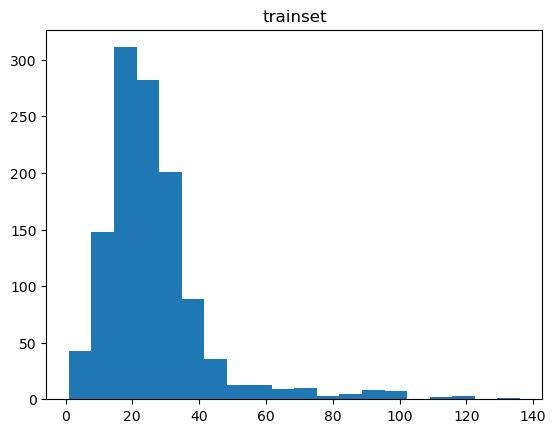

min/max : 1 136


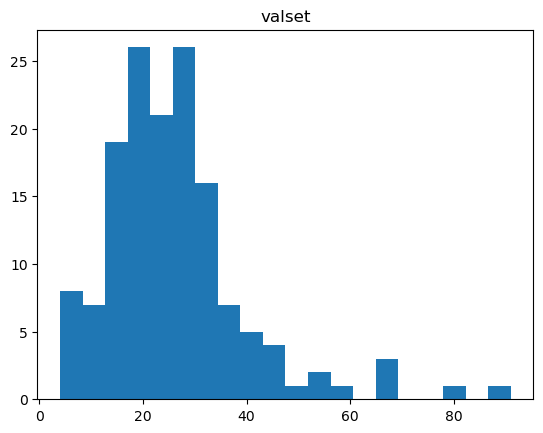

min/max : 4 91


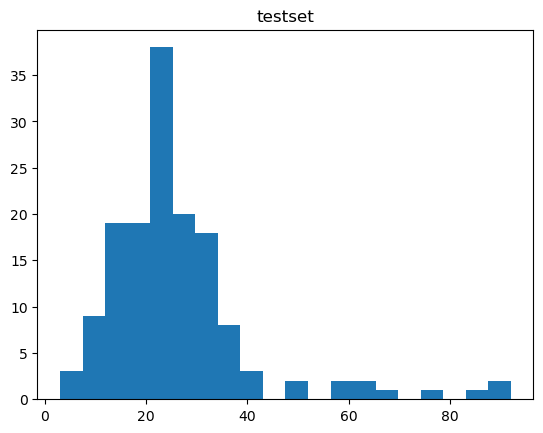

min/max : 3 92


In [14]:
def plot_histo_graphs(dataset, title):
    # histogram of graph sizes
    graph_sizes = []
    for graph in dataset:
        graph_sizes.append(graph[0].number_of_nodes())
    plt.figure(1)
    plt.hist(graph_sizes, bins=20)
    plt.title(title)
    plt.show()
    graph_sizes = torch.Tensor(graph_sizes)
    print('min/max :',graph_sizes.min().long().item(),graph_sizes.max().long().item())
    
plot_histo_graphs(dataset.train,'trainset')
plot_histo_graphs(dataset.val,'valset')
plot_histo_graphs(dataset.test,'testset')

In [9]:
atom_types = [
    'H', 'C', 'N', 'O', 'F', 'P', 'S', 'Cl', 'Br', 'I',  # 从BBBP
    'Ca', 'Na', 'B',  # 也来自BBBP
    'Mn', 'Zn', 'Co', 'Fe', 'Tl', 'Hg', 'Bi', 'Se', 'Cu', 'Au', 'Pt', 'Al', 'Ti', 'Tc', 'Si', 'As', 'Cr',  # 从Clintox
    '*',  # Clintox中包含的未知原子
    ]
    # 通过enumerate生成原子符号到索引的映射
atom_type_map = {atom: idx for idx, atom in enumerate(atom_types)} 
# 打印出映射
print(atom_type_map)

{'H': 0, 'C': 1, 'N': 2, 'O': 3, 'F': 4, 'P': 5, 'S': 6, 'Cl': 7, 'Br': 8, 'I': 9, 'Ca': 10, 'Na': 11, 'B': 12, 'Mn': 13, 'Zn': 14, 'Co': 15, 'Fe': 16, 'Tl': 17, 'Hg': 18, 'Bi': 19, 'Se': 20, 'Cu': 21, 'Au': 22, 'Pt': 23, 'Al': 24, 'Ti': 25, 'Tc': 26, 'Si': 27, 'As': 28, 'Cr': 29, '*': 30}


In [16]:
print(len(dataset.train))
print(len(dataset.val))
print(len(dataset.test))

print(dataset.train[0])
print(dataset.val[0])
print(dataset.test[0])

# print(dataset.train[0][0].ndata['atom_type'])
# print(dataset.train[0][0].ndata['atom_type'].shape)
print(dataset.train[0][0].ndata['feat'].shape)


print(dataset.train.graph_labels)
print(dataset.val.graph_labels)
print(dataset.test.graph_labels)

print(sum(1 for label in dataset.train.graph_labels if label == 1))
print(sum(1 for label in dataset.val.graph_labels if label == 1))
print(sum(1 for label in dataset.test.graph_labels if label == 1))

1184
148
148
(Graph(num_nodes=56, num_edges=124,
      ndata_schemes={'feat': Scheme(shape=(27,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(12,), dtype=torch.float32)}), [1, 0])
(Graph(num_nodes=39, num_edges=86,
      ndata_schemes={'feat': Scheme(shape=(27,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(12,), dtype=torch.float32)}), [1, 0])
(Graph(num_nodes=66, num_edges=148,
      ndata_schemes={'feat': Scheme(shape=(27,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(12,), dtype=torch.float32)}), [1, 0])
torch.Size([56, 27])
[[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1

In [17]:
#clintox_CT_TOX_PE 
start = time.time()
with open(project_root / 'ClinTox/clintox_8-1-1.pkl','wb') as f:
        pickle.dump([dataset.train,dataset.val,dataset.test,num_atom_type,num_bond_type],f)
print('Time (sec):',time.time() - start)

Time (sec): 0.5588698387145996


# Test load function

In [18]:
DATASET_NAME = 'ClinTox'
dataset = LoadData(DATASET_NAME,2)
print(dataset)
trainset, valset, testset = dataset.train, dataset.val, dataset.test

[I] 加载数据集 ClinTox...
[I] 正在加载数据集 ClinTox...
[I] 数据集 ClinTox 加载成功
训练集大小: 1184, 测试集大小: 148, 验证集大小: 148
[I] 数据加载完成，耗时: 0.3034s
[I] 成功加载数据集: ClinTox


In [19]:
batch_size = 10
collate = MoleculeDataset.collate
print(MoleculeDataset)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)

<class 'data.molecules.MoleculeDataset'>


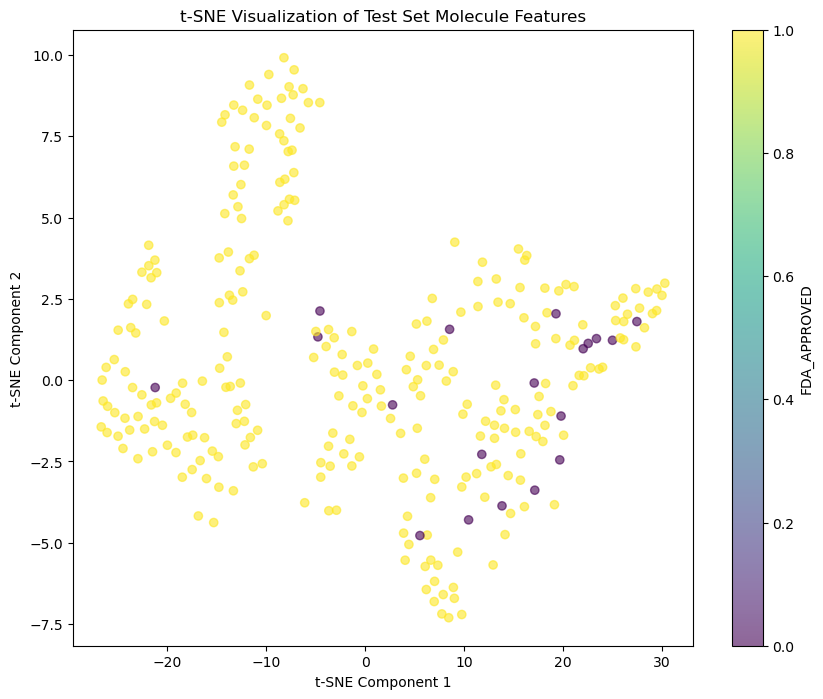

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 设置数据集路径
data_dir = project_root / 'ClinTox/clintox.csv.gz'
data_path = project_root / 'ClinTox/clintox.csv'
CLINTOX_TASKS = ['FDA_APPROVED', 'CT_TOX']

# 解压缩数据集
if not os.path.exists(data_path):
    with gzip.open(data_dir, 'rb') as f_in:
        with open(data_path, 'wb') as f_out:
            f_out.write(f_in.read())

# 读取数据集
df = pd.read_csv(data_path)

# 处理无效的 SMILES 字符串
valid_smiles = []
valid_indices = []
for i, smiles in enumerate(df['smiles']):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        valid_smiles.append(smiles)
        valid_indices.append(i)

# 使用有效索引过滤 DataFrame
df_valid = df.iloc[valid_indices].reset_index(drop=True)

# 提取图和标签
graphs = df_valid['smiles'].tolist()  # 保持为列表
labels = df_valid[CLINTOX_TASKS].values.tolist()  # 提取任务标签并转换为列表

# 将标签转换为 numpy 数组以便于分层抽样
labels_np = np.array(labels)

# 计算 split_num 确保测试集和训练集大小
split_num = int(len(labels_np) * 0.1)

# 初始化 StratifiedShuffleSplit 进行分层抽样
sss = StratifiedShuffleSplit(n_splits=1, test_size=split_num * 4, train_size=split_num * 6, random_state=42)

# 获取训练集和临时集（验证集+测试集）的索引
for train_index, temp_index in sss.split(np.zeros(len(labels_np)), labels_np[:, 0]):  # 使用第一个任务标签进行分层
    train_indices = train_index
    temp_indices = temp_index
    temp_labels = labels_np[temp_index]

# 进一步分割临时集为验证集和测试集
sss_val_test = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for val_index, test_index in sss_val_test.split(np.zeros(len(temp_labels)), temp_labels[:, 0]):  # 使用第一个任务标签进行分层
    val_indices = temp_indices[val_index]
    test_indices = temp_indices[test_index]

# 使用索引获取训练集、验证集和测试集
train_graphs = [graphs[i] for i in train_indices]
train_labels = [labels[i] for i in train_indices]
val_graphs = [graphs[i] for i in val_indices]
val_labels = [labels[i] for i in val_indices]
test_graphs = [graphs[i] for i in test_indices]
test_labels = [labels[i] for i in test_indices]

# 提取分子特征
def compute_features(smiles_list):
    features = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            feature_vector = [Descriptors.MolWt(mol), Descriptors.NumRotatableBonds(mol), Descriptors.TPSA(mol)]
            features.append(feature_vector)
    return np.array(features)

test_features = compute_features(test_graphs)

# 使用 t-SNE 进行降维
tsne = TSNE(n_components=2, random_state=42)
test_features_2d = tsne.fit_transform(test_features)

# 可视化 t-SNE 结果
plt.figure(figsize=(10, 8))
scatter = plt.scatter(test_features_2d[:, 0], test_features_2d[:, 1], c=np.array(test_labels)[:, 0], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label=CLINTOX_TASKS[0])
plt.title('t-SNE Visualization of Test Set Molecule Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()
